In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, make_scorer, accuracy_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer

In [3]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_sample_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
id_test = df_test['PassengerId']
print(f'Training data shape is {df_train.shape}')
print(f'Testing data shape is {df_test.shape}')

Training data shape is (891, 12)
Testing data shape is (418, 11)


In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Describing the data

In [7]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


As we can see, only the features ```Cabin``` and ```Age``` have null values. Since the Cabin has more than 50% null values, we delete that later, and impute Age null values.

# Exploratory data analysis

**Let's explore first numerical values**

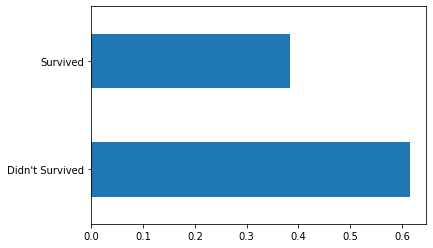

In [8]:
df_train['Survived'].replace({1:"Survived", 0: "Didn't Survived"}).value_counts(normalize=True).plot(kind='barh');

We can see that around 40% is the survival rate of the passengers

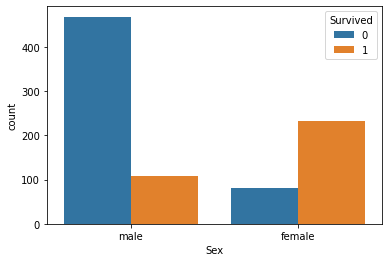

In [9]:
sns.countplot(data = df_train, x = 'Sex', hue='Survived');

- majority of the passengers are male
- female has higher survival rate than male

Now, Let's look the distribution of age in terms of the target

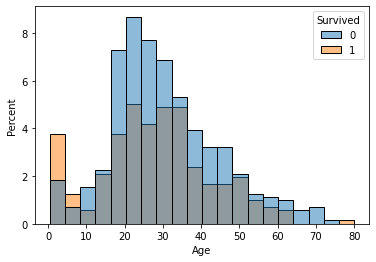

In [10]:
sns.histplot(data = df_train, x = 'Age', hue='Survived', stat='percent');

- Since most passengers are between 20 - 50 years old, survival rate in this age range is not high
- Age with <10 has a high survival rate
- the oldest survived

Now, Let's look the distribution of pclass in terms of the target

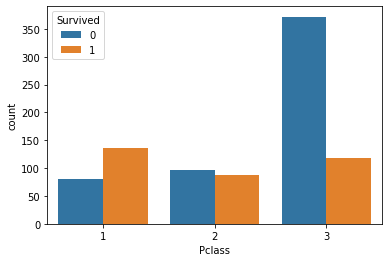

In [11]:
sns.countplot(data = df_train, x = 'Pclass', hue='Survived');

- majority of passengers were in class 3
- class 3 had the lowest survival rate
- class 2 had lower survival rate
- class 1 had the highest survival rate. This makes sense since the people in class 1 are considered rich people

Now let's observe sibsp, and Parch to see if the survival rate of people who are together with spouse/siblings/parents/childeren is high

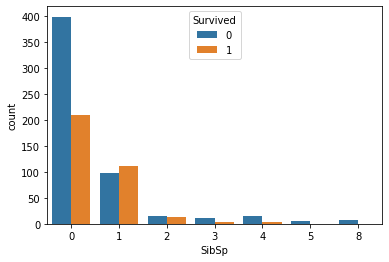

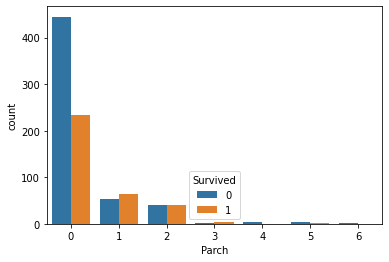

In [12]:
col = ['SibSp', 'Parch']

for i in col:
    sns.countplot(data = df_train, x = i, hue='Survived')
    plt.show();

- majority of the passenger do not have siblings/spouse or accompanied by their nannies
- the survival rate of those with only 1 sibling/children is high
- children without parents abourd and adults without spouse or siblings have the lowest survival rate
- people with most relatives aboard died
- we can transform this to the number of relatives by adding the two features

Now, let's check the correlation of the class and the fare. We delete one if they are correlated

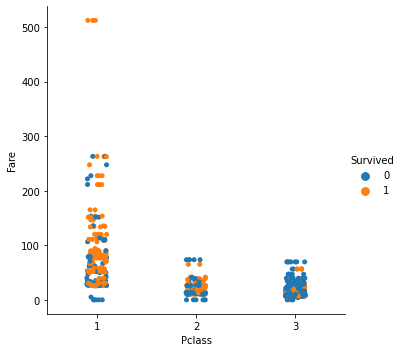

In [13]:
sns.catplot(data=df_train, x="Pclass", y="Fare", hue='Survived')

- class 1 has higher fare and high survival rate
- class 2 and 3 fare do not have significant difference and low survival rate
- There is moderate correlation, we are going to delete the fare on our feature selection section

Lastly, let's check **categorical features**. Let's do the following:
- Remove features with more than 50% null values
- Remove features with high/low cardinalty
- check the distribution

In [14]:
df_train.select_dtypes('object').nunique() / len(df_train)

Name        1.000000
Sex         0.002245
Ticket      0.764310
Cabin       0.164983
Embarked    0.003367
dtype: float64

- Name and Ticket are high-cardinality values

In [15]:
df_train.select_dtypes('object').isnull().sum() / len(df_train)

Name        0.000000
Sex         0.000000
Ticket      0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

- Cabin has more than 50% null values

There is only one categorical feature, let's look at the relationship embarked to the target vector using chi2

In [16]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2, chisquare
df_new = df_train[['Embarked', 'Survived']]
df_new = df_new.fillna(df_new['Embarked'].mode()[0]) #replace null values with most frequent
df_new['Embarked'] = df_new['Embarked'].replace({'C': 1, 'S': 2, 'Q': 3})

In [17]:
# contingency table
stat, p, dof, expected = chi2_contingency(df_new)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
#Hypotheses
print('H0: There is no significant relationship between the embarked and the survived')
print('H1: There is a significant relationship between the embarked and the survived')
#using CV method
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# using p-value method
alpha = 0.05 - prob
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

H0: There is no significant relationship between the embarked and the survived
H1: There is a significant relationship between the embarked and the survived
Independent (fail to reject H0)
Independent (fail to reject H0)


Here we can see that the two variables are not associated with each other. We can remove the feature Embarked

**Conclusion**
- All categorical features will be removed except ```Sex```
- Age, Pclass, and Gender are major factors to survive
- Tansform Parch and sibsp to the ```number of relatives``` by adding the two features
- Class and Fare are multicollinearities

# Modelling

## Feature Selection

In [18]:
def wrangle(file_path):
    # Read csv file
    df = pd.read_csv(file_path)
    # Remove values with more than 50% null values
    df.drop(columns = 'Cabin', inplace = True)
    # Remove high-cardinality features
    df.drop(columns = ['Name', 'PassengerId'], inplace = True)
    # Remove Multicollinearities
    df.drop(columns = 'Fare', inplace = True)
    # Remove all categorical features
    cat_cols = df.select_dtypes('object').drop(columns='Sex').columns.tolist()
    df.drop(columns = cat_cols, inplace = True)
    # Replace null values with median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    # Replace 'Sex' to numerical
    df['Sex'] = df['Sex'].replace({'female': 0, 'male': 1})
    return df

df = wrangle('/kaggle/input/titanic/train.csv')
df_test = wrangle('/kaggle/input/titanic/test.csv')

In [19]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


**This is the final data**

## Feature Engineering

Let's check the distribution of the data

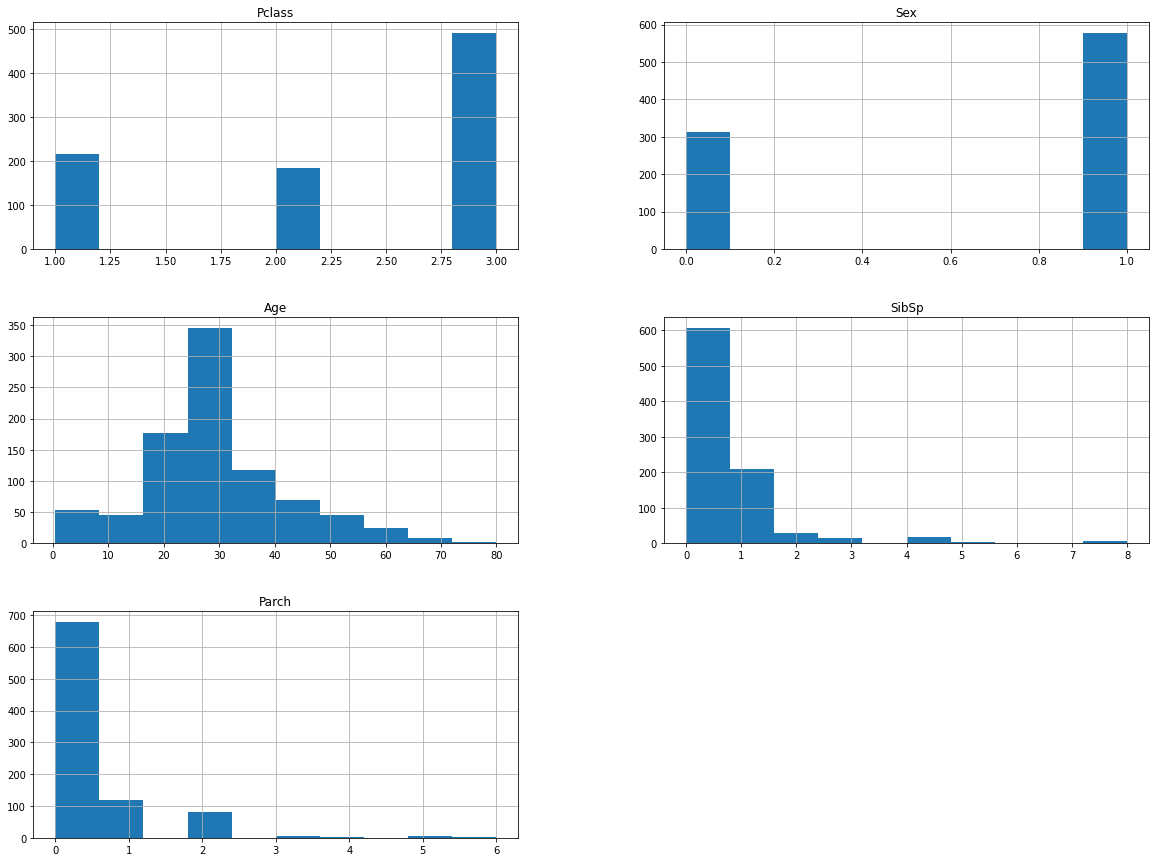

In [20]:
df.drop(columns='Survived').hist(figsize=(20,15), bins = 10);

We can see that the sibsp and Parch is highly skewed, we can transform that to log

In [21]:
cols = ['Parch', 'SibSp']
for col in cols:
    df[col] = np.log(df[col] + 1)
    df_test[col] = np.log(df_test[col] + 1)

Let's scale the age using standardscaler

In [22]:
ss = StandardScaler()
age =  np.asarray(df['Age'])
age = age.reshape(-1, 1)
df['Age'] = ss.fit_transform(age)
age_test =  np.asarray(df_test['Age'])
age_test = age_test.reshape(-1, 1)
df_test['Age'] = ss.fit_transform(age_test)

In [23]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,-0.565736,0.693147,0.0
1,1,1,0,0.663861,0.693147,0.0
2,1,3,0,-0.258337,0.000000,0.0
3,1,1,0,0.433312,0.693147,0.0
4,0,3,1,0.433312,0.000000,0.0


## Split

In [24]:
target = 'Survived'
X = df.drop(columns = target)
y = df[target]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(f'Training Data Shape: {X_train.shape} , {y_train.shape}')
print(f'Validation Data Shape: {X_val.shape} , {y_val.shape}')

Training Data Shape: (712, 5) , (712,)
Validation Data Shape: (179, 5) , (179,)


## Oversampling

<AxesSubplot:>

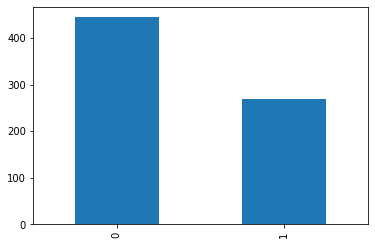

In [26]:
y_train.value_counts().plot(kind='bar')

as we can see, our data is imbalance. Let's try oversampling to balance the data

In [27]:
over_sampler = RandomOverSampler()
X_train_under, y_train_under = over_sampler.fit_resample(X_train, y_train)
print(f'Feature Matrix shape{X_train.shape}')
print(f'Target Vector shape{y_train.shape}')

Feature Matrix shape(712, 5)
Target Vector shape(712,)


In [28]:
f1_scores = []
accuracy_scores = []

def fit_model(clf):
    model = clf #make_pipeline(LabelEncoder(), clf)
    model.fit(X_train_under, y_train_under)
    f1 = f1_score(y_val, model.predict(X_val))
    accuracy = accuracy_score(y_val, model.predict(X_val))
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    print(f'F1 Scores: {f1}')
    print(f'Accuracy Scores: {accuracy}')
    print(f'Cross Validation Scores: {cross_val_score(model, X_train_under, y_train_under, cv = 5)}')
    
    return model

In [29]:
log_reg = fit_model(LogisticRegression())
DT = fit_model(DecisionTreeClassifier(random_state = 42))
RF = fit_model(RandomForestClassifier(random_state = 42))
GB = fit_model(GradientBoostingClassifier(random_state = 42))

F1 Scores: 0.7924528301886792
Accuracy Scores: 0.8156424581005587
Cross Validation Scores: [0.76966292 0.79213483 0.7752809  0.79096045 0.72881356]
F1 Scores: 0.6950354609929078
Accuracy Scores: 0.7597765363128491
Cross Validation Scores: [0.78089888 0.79213483 0.84831461 0.81920904 0.84745763]
F1 Scores: 0.7586206896551724
Accuracy Scores: 0.8044692737430168
Cross Validation Scores: [0.80898876 0.79213483 0.87078652 0.83615819 0.84180791]
F1 Scores: 0.8028169014084507
Accuracy Scores: 0.8435754189944135
Cross Validation Scores: [0.80898876 0.7752809  0.85393258 0.83615819 0.81355932]


# Hyper Parameter Tuning

In [30]:
def tune_params(clf, params = None):
    import time
    model = make_pipeline(clf)
    tuned_model = GridSearchCV(
        model,
        param_grid=params,
        scoring=['f1', 'accuracy'],
        cv =5,
        refit='accuracy',
        n_jobs = -1,
        verbose = 1
    )
    starting_time = time.time()
    tuned_model.fit(X_train, y_train)
    ending_time = time.time()
    elapse_time = ending_time - starting_time
    return tuned_model, elapse_time

In [31]:
dt_params = {
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': range(1, 31, 5),
}

rf_params = {
    'randomforestclassifier__n_estimators': range(10, 150, 10),
    'randomforestclassifier__max_depth': range(1, 31, 5),
}

gb_params = {
    'gradientboostingclassifier__n_estimators': range(10, 150, 10),
    'gradientboostingclassifier__max_depth': range(1, 31, 5),
}

DT_final_model, DT_training_time = tune_params(DecisionTreeClassifier(random_state = 42), dt_params)
RF_final_model, RF_training_time = tune_params(RandomForestClassifier(random_state = 42), rf_params)
GB_final_model, GB_training_time = tune_params(GradientBoostingClassifier(random_state = 42), gb_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [32]:
pd.DataFrame(DT_final_model.cv_results_).sort_values(by='rank_test_accuracy').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__splitter,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3,0.005164,0.000292,0.005812,0.002532,6,random,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.752475,0.755102,0.714286,0.608696,0.745098,0.715131,0.055172,1,0.825175,0.832168,0.802817,0.746479,0.816901,0.804708,0.030711,1
2,0.005636,0.000246,0.004481,0.000073,6,best,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.747475,0.721649,0.652174,0.639175,0.769231,0.705941,0.051626,3,0.825175,0.811189,0.774648,0.753521,0.830986,0.799104,0.030060,2
5,0.005492,0.000949,0.004299,0.000742,11,random,"{'decisiontreeclassifier__max_depth': 11, 'dec...",0.742268,0.722222,0.625000,0.700000,0.785047,0.714907,0.052966,2,0.825175,0.790210,0.746479,0.788732,0.838028,0.797725,0.032067,3
0,0.005903,0.000435,0.004785,0.000618,1,best,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.712871,0.742857,0.666667,0.639175,0.761905,0.704695,0.045902,4,0.797203,0.811189,0.753521,0.753521,0.823944,0.787876,0.029298,4
1,0.005056,0.000218,0.004371,0.000244,1,random,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.712871,0.742857,0.666667,0.639175,0.761905,0.704695,0.045902,4,0.797203,0.811189,0.753521,0.753521,0.823944,0.787876,0.029298,4


In [33]:
pd.DataFrame(RF_final_model.cv_results_).sort_values(by='rank_test_accuracy').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
26,0.404325,0.013859,0.038086,0.008402,6,130,"{'randomforestclassifier__max_depth': 6, 'rand...",0.770833,0.792079,0.673684,0.715789,0.767677,0.744013,0.043203,7,0.846154,0.853147,0.781690,0.809859,0.838028,0.825776,0.026501,1
25,0.342368,0.006418,0.029433,0.000477,6,120,"{'randomforestclassifier__max_depth': 6, 'rand...",0.770833,0.792079,0.673684,0.715789,0.767677,0.744013,0.043203,7,0.846154,0.853147,0.781690,0.809859,0.838028,0.825776,0.026501,1
15,0.069284,0.009719,0.010203,0.000781,6,20,"{'randomforestclassifier__max_depth': 6, 'rand...",0.778947,0.792079,0.694737,0.688172,0.750000,0.740787,0.042570,25,0.853147,0.853147,0.795775,0.795775,0.830986,0.825766,0.025790,3
24,0.314419,0.005514,0.028378,0.001008,6,110,"{'randomforestclassifier__max_depth': 6, 'rand...",0.770833,0.792079,0.673684,0.708333,0.767677,0.742521,0.044267,16,0.846154,0.853147,0.781690,0.802817,0.838028,0.824367,0.027478,4
23,0.289404,0.005245,0.026638,0.001117,6,100,"{'randomforestclassifier__max_depth': 6, 'rand...",0.762887,0.792079,0.687500,0.708333,0.760000,0.742160,0.038397,21,0.839161,0.853147,0.788732,0.802817,0.830986,0.822969,0.023729,5


In [34]:
pd.DataFrame(GB_final_model.cv_results_).sort_values(by='rank_test_accuracy').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
11,0.099152,0.000199,0.006121,0.000190,1,120,"{'gradientboostingclassifier__max_depth': 1, '...",0.745098,0.764706,0.718447,0.666667,0.769231,0.732830,0.037619,1,0.818182,0.832168,0.795775,0.774648,0.830986,0.810352,0.022137,1
12,0.106985,0.000571,0.006157,0.000544,1,130,"{'gradientboostingclassifier__max_depth': 1, '...",0.745098,0.764706,0.718447,0.666667,0.769231,0.732830,0.037619,1,0.818182,0.832168,0.795775,0.774648,0.830986,0.810352,0.022137,1
10,0.091745,0.000840,0.006083,0.000286,1,110,"{'gradientboostingclassifier__max_depth': 1, '...",0.752475,0.764706,0.705882,0.666667,0.769231,0.731792,0.039561,3,0.825175,0.832168,0.788732,0.774648,0.830986,0.810342,0.023932,3
13,0.114434,0.000889,0.006073,0.000268,1,140,"{'gradientboostingclassifier__max_depth': 1, '...",0.745098,0.752475,0.718447,0.666667,0.769231,0.730383,0.035822,4,0.818182,0.825175,0.795775,0.774648,0.830986,0.808953,0.020901,4
8,0.076021,0.000528,0.006174,0.000194,1,90,"{'gradientboostingclassifier__max_depth': 1, '...",0.752475,0.752475,0.705882,0.666667,0.769231,0.729346,0.037789,5,0.825175,0.825175,0.788732,0.774648,0.830986,0.808943,0.022792,5


In [35]:
print(GB_final_model.best_score_)
print(RF_final_model.best_score_)
print(DT_final_model.best_score_)

0.8103516202107752
0.8257756328178865
0.8047079680882498


In [36]:
log_reg = fit_model(LogisticRegression())
DT = fit_model(DecisionTreeClassifier(max_depth = 6, splitter='random', random_state = 42))
RF = fit_model(RandomForestClassifier(max_depth = 6, n_estimators = 130, random_state = 42))
GB = fit_model(GradientBoostingClassifier(max_depth = 1, n_estimators = 130, random_state = 42))

F1 Scores: 0.7924528301886792
Accuracy Scores: 0.8156424581005587
Cross Validation Scores: [0.76966292 0.79213483 0.7752809  0.79096045 0.72881356]
F1 Scores: 0.7605633802816901
Accuracy Scores: 0.8100558659217877
Cross Validation Scores: [0.78651685 0.78651685 0.79775281 0.80225989 0.76271186]
F1 Scores: 0.8028169014084507
Accuracy Scores: 0.8435754189944135
Cross Validation Scores: [0.81460674 0.81460674 0.80337079 0.81920904 0.83050847]
F1 Scores: 0.7517730496453902
Accuracy Scores: 0.8044692737430168
Cross Validation Scores: [0.78089888 0.80898876 0.78651685 0.81920904 0.75141243]


The best algorithm is RandomForest

In [37]:
y_pred = RF.predict(df_test)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [38]:
submit = pd.DataFrame({
    'PassengerId': id_test,
    'Survived': y_pred
})
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [39]:
submit.to_csv('Submission.csv', index = False)